# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [ ]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### Loading files

In [ ]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

exclude = 35
Bk_all = np.delete(Bk_all, exclude, axis=0)
p_all = np.delete(p_all, exclude, axis=0)

### A few plotting routines

#### Experimental design

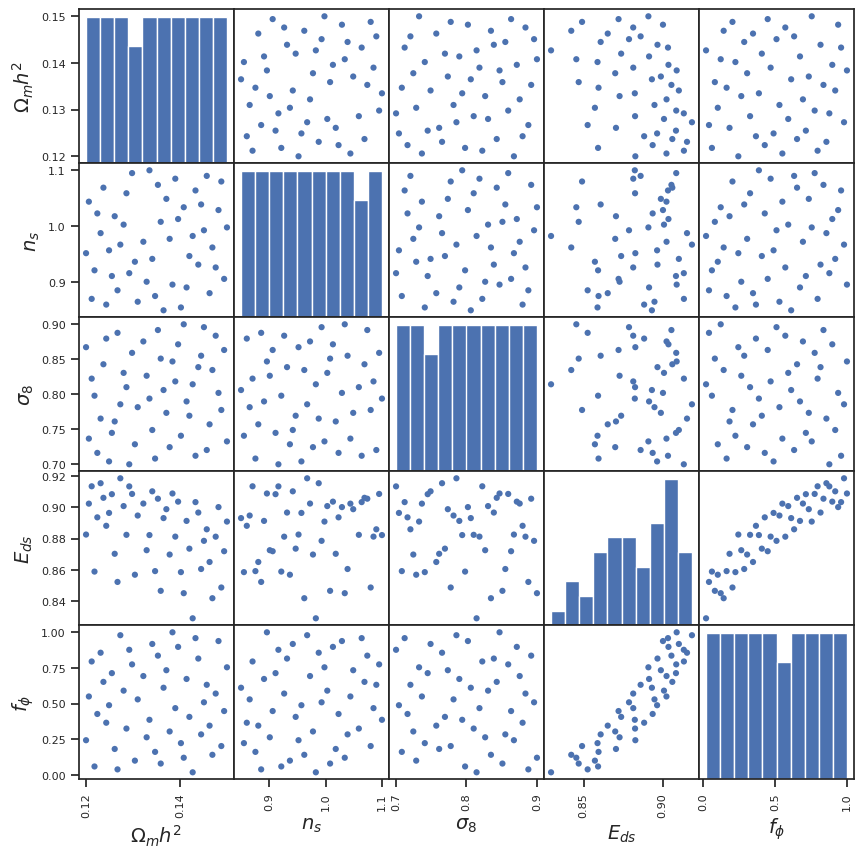

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);

#### Boost metrics colored by cosmology parameters

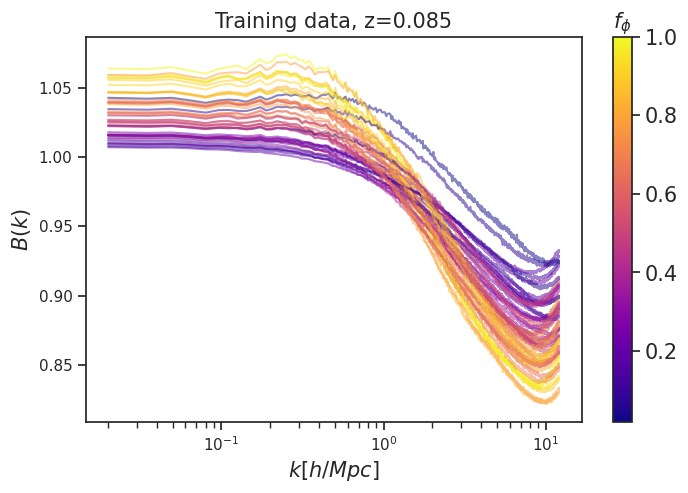

In [ ]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

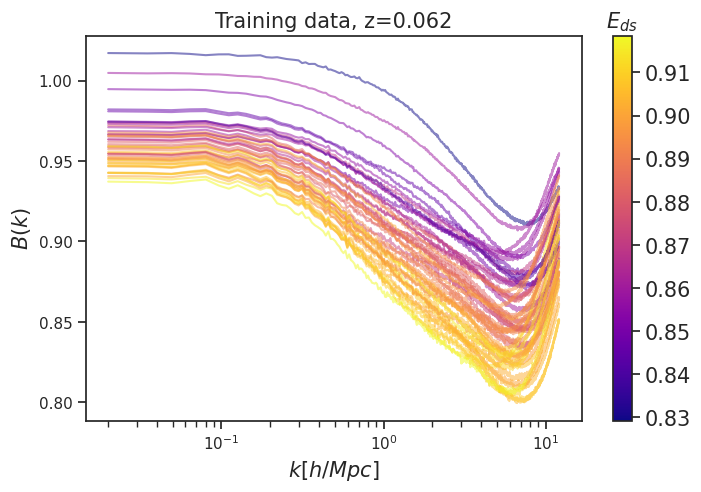

In [ ]:
color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

### Training involves: PCA, GP fitting.  

In [ ]:
z_index = 9
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all
sepia_data = sepia_data_format(p_all, y_vals, y_ind)
print(sepia_data)
model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 


sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, model_filename)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]
 [0.1]]
lamUz
[[5.]]
lamWs
[[100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.23it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.6933566 ]
 [0.71309943]
 [0.09450764]
 [0.23297867]
 [0.80826699]
 [0.09229774]]
lamUz
[[0.71228768]]
lamWs
[[3113.85361639]]
lamWOs
[[0.01077878]]


MCMC sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.12it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index9.pkl


In [ ]:
Bk_all.shape

(49, 51, 768)

### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

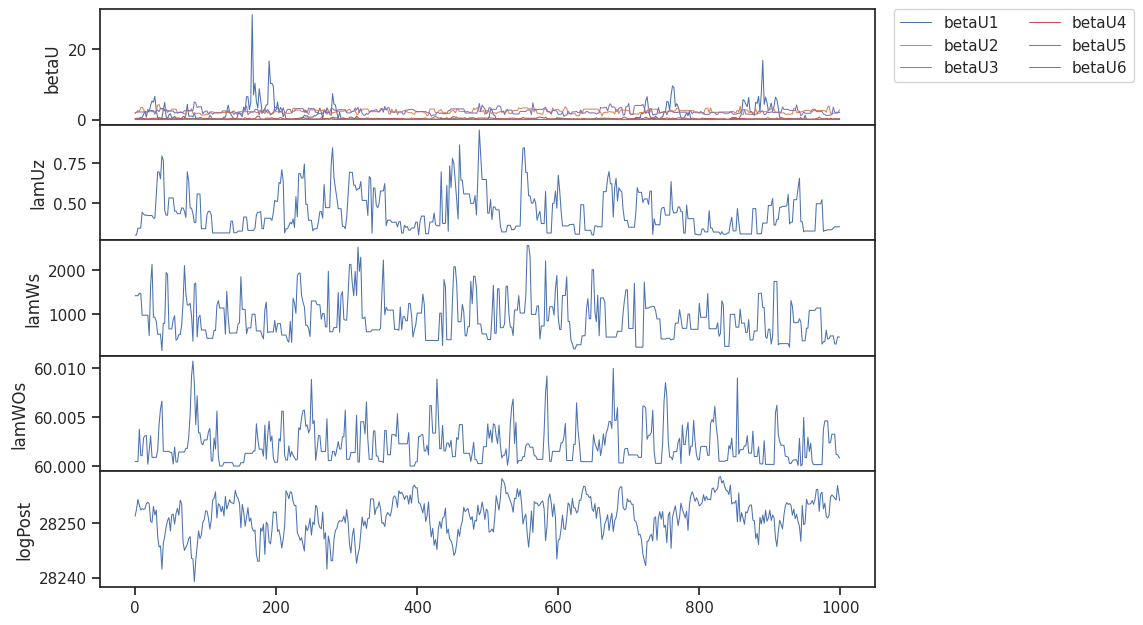

In [ ]:
plot_train_diagnostics(sepia_model)

### Single-redshift emulation for new cosmological parameters

In [ ]:
test_indices = [0, 1, 3, 4, 5]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

pred_mean, pred_quant = emulate(sepia_model, input_params)

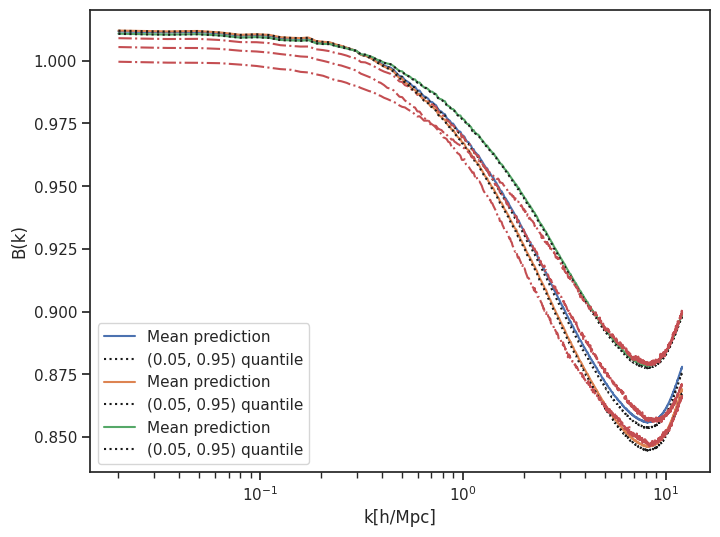

In [ ]:
f, a = plt.subplots(1, 1, figsize=(8, 6))

for one_index in range(3):
    # one_index = 0
    a.plot(k_all, pred_mean[:, one_index], label='Mean prediction')
    a.plot(k_all, pred_quant[:, one_index, 0],'k:', label='(0.05, 0.95) quantile')
    a.plot(k_all, target_vals[one_index], 'r-.')
a.set_xlabel('k[h/Mpc]')
a.set_ylabel('B(k)')
a.set_xscale('log')
plt.legend()
plt.show()

### Sensitivity analysis from the emulator 

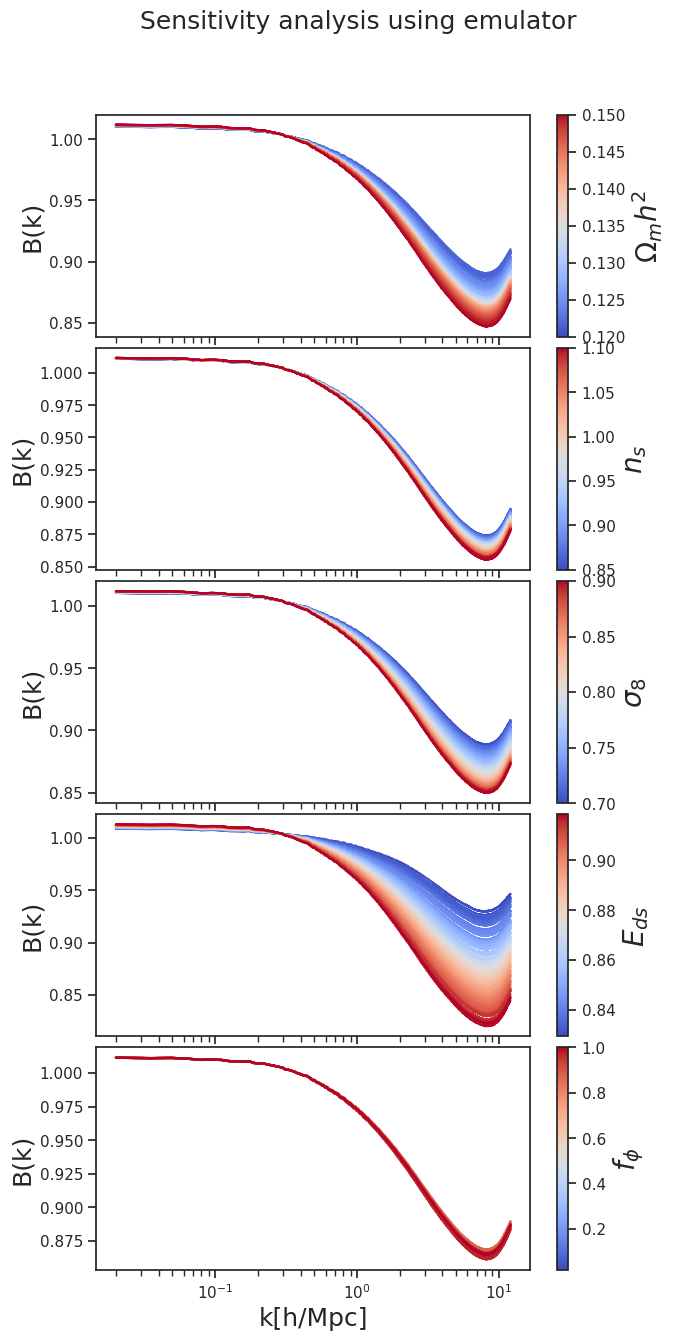

In [ ]:
sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME)

### Multi-redshift emulation

#### Train all the models

In [ ]:
def do_gp_train_multiple(model_dir:str=None, # Pickle directory path
                         z_index_range:np.array=None, # Snapshot indices for training
                   ) -> None: 
    
    for z_index in z_index_range:
        y_vals = Bk_all[:, z_index, :]
        # y_ind = np.arange(0, y_vals.shape[1])
        y_ind = k_all
        sepia_data = sepia_data_format(p_all, y_vals, y_ind)
        print(sepia_data)
        model_filename = model_dir + 'multivariate_model_z_index' + str(z_index) 


        sepia_model = do_pca(sepia_data, exp_variance=0.95)
        sepia_model = do_gp_train(sepia_model, model_filename)
        print('Training complete for snapshot ' + str(z_index))
        print('Model saved at ' + model_dir)
        print(30*'=*')
    
    return None

In [ ]:
do_gp_train_multiple(model_dir='../CubicGalileonEmu/model/', z_index_range=np.arange(50, 51))

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.18it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.68393955 0.22247071]
 [0.44976622 0.24984435]
 [0.0517869  0.09026317]
 [0.11775197 0.33145113]
 [0.59144185 0.94363716]
 [0.0607212  0.41159152]]
lamUz
[[0.80637893 0.60502125]]
lamWs
[[3964.97369847 3704.54468524]]
lamWOs
[[0.06499538]]


MCMC sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.47it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index50.pkl
Training complete for snapshot 50
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


### Parameter inference using the emulator